# Forecasting Energy Markets

## Introduction
Over the past several years, global events have rocked the energy markets: the Covid-19 pandemic caused the price of oil to crash, while a combination of inflation and the sanctions placed on Russia due to its invasion of Ukraine have caused the price of oil and natural gas to skyrocket. As a result, it is important to be able to forecast energy markets accurately despite global uncertainty.

With this in mind, my project aims at developing a tool to forecast energy markets consistently and accurately in a time-effective manner. This tool can help governments allocate resources efficiently and help investors optimize trading futures. Specficially, by pulling publicly available data, I will train different univariate models on past values to forecast future values.

## Tools
I will be creating these models using Python. In particular, I will be using the pandas and numpy libraries to clean the data, the requests and json libraries to pull and parse the data, and the sklearn library to prepare the data. I will be using a XGBoost regressor, a Support Vector regressor, and a Random Forest regressor to forecast the data.

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import math
import datetime

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from pylab import rcParams
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['figure.figsize'] = 12,6

## Pulling the Data

### U.S. Energy Information Administration
The U.S. Energy Information Administration (EIA) collects and disseminates energy data to the public to promote efficient markets, sound policy making, and public education. The EIA makes its data available through dashbarods available here: https://www.eia.gov/tools/. For people who want to pull data locally, the EIA provides documentation for their API here: https://www.eia.gov/opendata/documentation.php. To pull the data, one needs to register an API key. I blurred mine out, but one can easily be obtained from their website. However, their API has several problems. The first is that when trying to determine which data to pull, the options are often hidden, making querying data tedious. Additionally, the maximum number of points that can be pulled per request is 5000 datapoints. If one wants to pull more data, they would either have to paginate or or filter their data in the API call, as opposed to in a dataframe tool, like Pandas, which would be typically more well known by the user. My first class, LoadQuery, addresses these issues.

The class LoadQuery begins by looping through the different pages available, from which the user can select which data they want while having all options available, and then choose which dataset they want to pull. Next, the user will choose the periodicity of the data, if it comes in multiple formats, as well as the type of data that they want to pull, again, if the data comes in mulitple formats. Once chosen, the program will then paginate through the queries until all data is pulled. The data is then turned into a Pandas dataframe format, which can be accessed through the .df attribute of the LoadQuery object. The dataframe will be indexed by date.

In [2]:
date_switch = {'annual':'%Y',
                   'monthly':'%Y-%m',
                   'daily':'%Y-%m-%d'}

class LoadQuery:
    def __init__(self, header = "",page = "", key = "",data = None, frequency = None,response = None, df = None, format = None):
        self.header = 'https://api.eia.gov/v2'
        self.page = page ##Which page you want to access. Created by running load_page
        self.key= '?api_key=tOaGfQVYpnihnfZ0cAxBSggTFmwxkpwE26NTN0LJ'
        self.data = data ##The data you want to access with the query. Created by running choose_query
        self.frequency = frequency
        self.response = response
        self.df = df
        self.format = format
        
    def load_page(self):
        ##When running load_page, this creates 
        api_url = self.header+self.page+self.key
        response = requests.get(api_url)#, verify = False)
        response = response.json()
        if 'frequency' not in response['response'].keys():
            print('Choose your id')
            check = []
            for i in response['response']['routes']:
                print("id: ", i['id'], " Name: ", i['name'],'\r')
                check.append(i['id'])
            next_page = input()
            if next_page not in check:
                print('What you typed was not an option')
                self.load_page()
            else:
                self.page+='/'+next_page
                self.load_page()
        api_url = self.header+self.page+self.key
        response = requests.get(api_url)
        self.response = response.json()
    

    def choose_frequency(self):
        if len(self.response['response']['frequency']) == 1:
            self.frequency = self.response['response']['frequency'][0]['id']
        else:
            print('Choose the frequency')
            check = []
            for i in self.response['response']['frequency']:
                check.append(i['id'])
                print(i['id'])
            frequency = input()
            if frequency in check:
                self.frequency = frequency
            else:
                print('What you typed was not an option')
                self.choose_frequency()
    
    def choose_data(self):
        if len(self.response['response']['data'].keys()) == 1:
            self.data = list(self.response['response']['data'].keys())[0]
        else:
            print('Choose the data type')
            check = []
            for i in self.response['response']['data'].keys():
                check.append(i)
                print(i)
            data = input()
            if data in check:
                self.data = data
            else:
                print('What you typed was not an option')
                self.choose_data()

    def create_info(self):
        api_url = self.header+self.page+self.key+'&data[]='+self.data+'&frequency='+self.frequency
        response = requests.get(api_url)
        self.response = response.json()    
    
    def create_every_response(self):
        self.format = date_switch[self.frequency]
        api_url = self.header+self.page+"/data"+self.key+'&data[]='+self.data+'&frequency='+self.frequency
        response = requests.get(api_url)
        data = response.json()
        final = data['response']['data']
        total = data['response']['total']
        offset = 5000
        if total <= 5000:
            self.response = final
        else:
            num_loops = math.floor(total/5000)
            offset = 5000
            for i in range(0,num_loops):
                api_url = self.header+self.page+"/data"+self.key+'&data[]='+self.data+'&frequency='+self.frequency+'&offset='+str(offset)
                response = requests.get(api_url)
                data = response.json()
                final += data['response']['data']
                offset += 5000
                percent = (offset-5000)/total*100
                print("%.2f"%percent,'% of the way done')
            self.response = final

    def get_total_number_of_data_points(self):
        api_url = self.header+self.page+"/data"+self.key+'&data[]='+self.data+'&frequency='+self.frequency
        response = requests.get(api_url)
        response = response.json()
        return response['response']['total']
    
    def create_df(self):
        api_url = self.header+self.page+"/data"+self.key+'&data[]='+self.data+'&frequency='+self.frequency
        response = requests.get(api_url)
        data = response.json()
        self.df = pd.DataFrame(data['response']['data'])
    
    def return_url(self):
        url = self.header+self.page+"/data"+self.key+'&data[]='+self.data+'&frequency='+self.frequency
        return url
        
    def create_data_df(self):
        self.df = pd.DataFrame(self.response)
    
    def create_index(self):
        self.df['period'] = pd.to_datetime(self.df['period'],format = self.format)
        self.df['time_idx'] = pd.DatetimeIndex(self.df['period'])
        self.df = self.df.set_index('time_idx')
        self.df = self.df.sort_values('time_idx')

    def run_all(self):
        self.load_page()
        self.choose_frequency()
        self.choose_data()
        self.create_info()
        self.create_every_response()
        self.df = pd.DataFrame(self.response).drop_duplicates()
        self.create_index()
        print('Data has been obtained')

## Building the Models

To build and determine the best model, I built the ForecastModel class below. A ForecastModel object takes four parameters: the data one wants to forecast which was pulled from the query, the number of past periods to train the models on, the number of periods to forecast, and the name of the column in the dataframe being passed that contains the data.

I perform a GridSearch across a Support Vector regressor, a XGBoost regressor, and a RandomForest regressor. First, I

To build the models, I first call the shift_values() method to shift the values being predicted up a row so that the features in each row will forecast the value for the next day. Next, I call train_models(), which calls the models and performs a GridSearch, trains each model on a 80/20 split, and then performs a forecast by using the datapoints forecasted as the features. I then store the error and the predictions for each model. Afterwards, I align the predictions with the dates they correspond to through update_df().

Finally, I call plot_best_model() to plot with the smallest MAE, while plot_data() plots all three models trained from the GridSearch. Calling find_best_model() works through the above steps and plots the best model. Calling the regerssors attribute will display the final models created for each regressor. Below, I work through two examples.

In [13]:
params = {
'Support Vector Regressor':{"C": [0.5, 0.7], 'kernel':['rbf', 'poly']},
'RandomForest':{'max_features':[1.0,'sqrt'],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4],'bootstrap':[True,False]},
'XGBoost':{'min_child_weight': [5, 7, 9],'colsample_bytree': [0.2, 0.4, 0.6],'max_depth': [5, 7, 9]}
}

class ForecastModel:
    def __init__(self, df=None, num_shifts = None, num_predict = None, col = None, 
                 error = None, test=None, predictions = None, final_df = None, final_date = None, first_date = None, regressors=None):
        self.df = df
        self.col = col
        self.num_shifts = num_shifts
        self.num_predict = num_predict
        self.data = self.shift_values()
        self.error = error
        self.test = test
        self.predictions = predictions
        self.final_df = final_df
        self.final_date = final_date
        self.first_date = first_date
        self.regressors = regressors
    
    def create_regressors(self):
        regressors = {
            'Support Vector Regressor': [SVR()],
            'RandomForest':[RandomForestRegressor()],
            'XGBoost': [XGBRegressor()]
        }
        self.regressors = regressors

    def shift_values(self):
        df_dummy = self.df[[self.col]].copy()
        for i in range(1,self.num_shifts+1):
            name = self.col + "_shift " + str(i)
            df_dummy[name] = df_dummy[self.col].shift(i)
        df_dummy[self.col] = df_dummy[self.col].shift(-1)
        df_dummy = df_dummy.dropna(how='any',axis=0)
        y = df_dummy[self.col]
        X = df_dummy.drop(self.col,axis=1)
        return X,y

    def train_models(self):
        X,y = self.shift_values()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        X_pred = X_test[0]
        self.create_regressors()
        for reg in self.regressors:
            print('Training '+reg)
            model = self.regressors[reg][0]
            #model.fit(X_train, y_train)
            grid = GridSearchCV(model, params[reg])
            grid.fit(X_train, y_train)
            model = grid.best_estimator_
            self.regressors[reg][0] = model
            for i in range(0,len(X_test)-1):
                new = model.predict([X_pred])
                if i == 0:
                    predictions = np.array([new[0]])
                else:
                    predictions = np.append(predictions,np.array([new[0]]))
                X_pred = np.insert(X_pred,0,predictions[-1])[0:self.num_shifts]
#                 X_pred[i+1] = np.concatenate([new,X_test[i+1][:-1]])
            error = mean_absolute_error(y_test[:-1], predictions)
            self.regressors[reg].append(error)
            self.regressors[reg].append(predictions)   
            print(reg+' trained')
        self.test = y_test

    def update_df(self):
        first_date = None
        final_date = None
        length = len(self.df[self.df[self.col] == self.test[0]].index)
        for i in range(0,length):
            x = self.df.index.get_loc(self.df[self.df[self.col] == self.test[0]].index[i])
            new = x + len(self.test) - 1
            if self.df.iloc[new]['value'] == self.test[-1]:
                first_date = x
                final_date = new + 1
                break
        self.first_date = first_date
        self.final_date = final_date
        self.final_df = self.df.iloc[first_date:final_date][[self.col]].copy()[:-1]
        self.final_df['test'] = self.test[:-1]
        for reg in self.regressors:
            self.final_df[reg+' preds'] = self.regressors[reg][2]
            
            
    def plot_best_model(self):
        left = 500
        right = 100
        min_error = self.regressors['Support Vector Regressor'][1]
        best_model_name = 'Support Vector Regressor'
        for reg in self.regressors:
            if self.regressors[reg][1] < min_error:
                min_error = self.regressors[reg][1]
                best_model_name = reg
        
        plt.plot(self.df[self.col], label = 'Actuals', color = 'black')
        plt.plot(self.final_df[best_model_name+' preds'], label = best_model_name+' Predictions', color = 'blue')
        corr = str(round(self.final_df.corr()[best_model_name+' preds']['value'],3))
        min_error_name = ' MAE: %.3f' % min_error
        plt.title(best_model_name+' Predictions $r^2$: '+corr+min_error_name)
        plt.legend()
        plt.show()
        
        plt.plot(self.df[self.col][self.first_date - left:self.final_date + right], label = 'Actuals', color = 'black')
        plt.plot(self.final_df[best_model_name+' preds'], label = best_model_name+' Predictions', color = 'blue')
        corr = str(round(self.final_df.corr()[best_model_name+' preds']['value'],3))
        plt.title(best_model_name+' Predictions $r^2$: '+corr+min_error_name)
        plt.legend()
        plt.show()
        
    def find_best_model(self):
        self.train_models()
        self.update_df()
        self.plot_best_model()
            
    def plot_data(self):
        left = 500
        right = 100
        
        for reg in self.regressors:
            min_error = ' MAE: %.3f' % self.regressors[reg][1]
            rcParams['figure.figsize'] = 20,10
            plt.plot(self.df[self.col][self.first_date - left:self.final_date + right], label = 'Previous', color = 'black')
            plt.plot(self.final_df[reg+' preds'], label = reg+' Predictions', color = 'blue')
            corr = str(round(self.final_df.corr()[reg+' preds']['value'],3))
            plt.title(reg+' Predictions $r^2$: '+corr+min_error)
            plt.legend()
            plt.show()

In [8]:
test = np.array([1,2,3,4,5])

In [11]:
np.insert(test,0,-5)[0:len(test)]

array([-5,  1,  2,  3,  4])

## Forecasting Natural Gas Futures
Below, I walk through the process outlined above to forecast natural gas futures. Specifically, I will be forecasting the Contract 1 futures prices. Because natural gas contracts expire three business days prior to the first calendar day of the delivery month, Contract 1 contains the calendar month following the trade date. Information can be found at this link: https://www.eia.gov/dnav/ng/TblDefs/ng_pri_fut_tbldef2.asp.

Below, I create a LoadQuery object to pull the data that I want to forecast.

In [4]:
natural_gas_query = LoadQuery()
natural_gas_query.run_all()

Choose your id
id:  coal  Name:  Coal 
id:  crude-oil-imports  Name:  Crude Oil Imports 
id:  electricity  Name:  Electricity 
id:  international  Name:  International 
id:  natural-gas  Name:  Natural Gas 
id:  nuclear-outages  Name:  Nuclear Outages 
id:  petroleum  Name:  Petroleum 
id:  seds  Name:  State Energy Data System (SEDS) 
id:  steo  Name:  Short Term Energy Outlook 
id:  densified-biomass  Name:  Densified Biomass 
id:  total-energy  Name:  Total Energy 
id:  aeo  Name:  Annual Energy Outlook 
id:  ieo  Name:  International Energy Outlook 
id:  co2-emissions  Name:  State CO2 Emissions 
natural-gas
Choose your id
id:  sum  Name:  Summary 
id:  pri  Name:  Prices 
id:  enr  Name:  Exploration and Reserves 
id:  prod  Name:  Production 
id:  move  Name:  Imports and Exports/Pipelines 
id:  stor  Name:  Storage 
id:  cons  Name:  Consumption / End Use 
pri
Choose your id
id:  sum  Name:  Natural Gas Prices 
id:  fut  Name:  Natural Gas Spot and Futures Prices (NYMEX) 
id:  r

Now that the data has been obtained, I call the dataframe to see the different features and how to filter for Contract 1.

In [10]:
natural_gas_query.df.head().to_markdown()

'| time_idx            | period              | duoarea   | area-name     | product   | product-name   | process   | process-name      | series   | series-description                                       |   value | units   |\n|:--------------------|:--------------------|:----------|:--------------|:----------|:---------------|:----------|:------------------|:---------|:---------------------------------------------------------|--------:|:--------|\n| 1993-12-20 00:00:00 | 1993-12-20 00:00:00 | Y35NY     | NEW YORK CITY | EPG0      | Natural Gas    | PE4       | Future Contract 4 | RNGC4    | Natural Gas Futures Contract 4 (Dollars per Million Btu) |   1.894 | $/MMBTU |\n| 1993-12-21 00:00:00 | 1993-12-21 00:00:00 | Y35NY     | NEW YORK CITY | EPG0      | Natural Gas    | PE4       | Future Contract 4 | RNGC4    | Natural Gas Futures Contract 4 (Dollars per Million Btu) |   1.83  | $/MMBTU |\n| 1993-12-22 00:00:00 | 1993-12-22 00:00:00 | Y35NY     | NEW YORK CITY | EPG0      | Natural G

In [64]:
natural_gas_query.df['series-description'].unique()

array(['Natural Gas Futures Contract 4 (Dollars per Million Btu)',
       'Natural Gas Futures Contract 2 (Dollars per Million Btu)',
       'Natural Gas Futures Contract 1 (Dollars per Million Btu)',
       'Natural Gas Futures Contract 3 (Dollars per Million Btu)',
       'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'],
      dtype=object)

I will filter on the series description 'Natural Gas Futures Contract 1 (Dollars per Million Btu)'.

In [5]:
series_desc = 'Natural Gas Futures Contract 1 (Dollars per Million Btu)'
natural_gas_data = natural_gas_query.df[(natural_gas_query.df['series-description'] == series_desc)]
natural_gas_data = natural_gas_data.dropna()
natural_gas_data.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
time_idx,,,,,,,,,,,
1994-01-13,1994-01-13,Y35NY,NEW YORK CITY,EPG0,Natural Gas,PE1,Future Contract 1,RNGC1,Natural Gas Futures Contract 1 (Dollars per Mi...,2.194,$/MMBTU
1994-01-14,1994-01-14,Y35NY,NEW YORK CITY,EPG0,Natural Gas,PE1,Future Contract 1,RNGC1,Natural Gas Futures Contract 1 (Dollars per Mi...,2.268,$/MMBTU
1994-01-17,1994-01-17,Y35NY,NEW YORK CITY,EPG0,Natural Gas,PE1,Future Contract 1,RNGC1,Natural Gas Futures Contract 1 (Dollars per Mi...,2.360,$/MMBTU
1994-01-18,1994-01-18,Y35NY,NEW YORK CITY,EPG0,Natural Gas,PE1,Future Contract 1,RNGC1,Natural Gas Futures Contract 1 (Dollars per Mi...,2.318,$/MMBTU
1994-01-19,1994-01-19,Y35NY,NEW YORK CITY,EPG0,Natural Gas,PE1,Future Contract 1,RNGC1,Natural Gas Futures Contract 1 (Dollars per Mi...,2.252,$/MMBTU


I create the model by passing the dataframe natural_gas_data, train the model by having the preivous 50 days predict the next day, forecast the next 150 days, and use the data in the column "value".

After training the models, the best model is graphed below. The Support Vector regressor was the best model, and had an $r^{2}$ value of 0.982 with the testing data and a mean average error of 0.190.

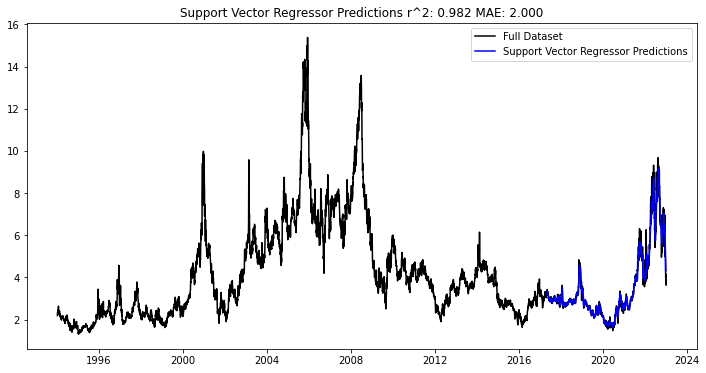

In [65]:
best_model_name = 'Support Vector Regressor'
min_error = 2
natural_gas_forecast.final_df
plt.plot(natural_gas_forecast.df[natural_gas_forecast.col], label = 'Full Dataset', color = 'black')
plt.plot(natural_gas_forecast.final_df[best_model_name+' preds'], label = best_model_name+' Predictions', color = 'blue')
corr = str(round(natural_gas_forecast.final_df.corr()[best_model_name+' preds']['value'],3))
min_error_name = ' MAE: %.3f' % min_error
plt.title(best_model_name+' Predictions $r^2$: '+corr+min_error_name)
plt.legend()
plt.show()
        

Training Support Vector Regressor
Support Vector Regressor trained
Training RandomForest
RandomForest trained
Training XGBoost
XGBoost trained


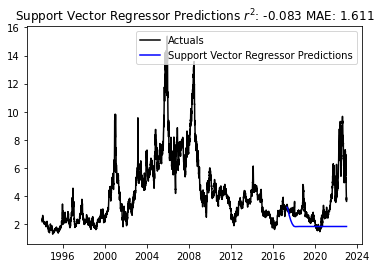

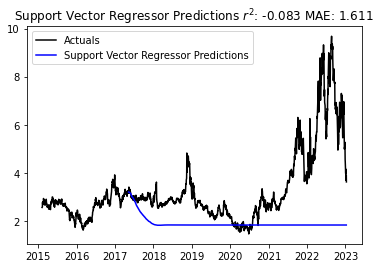

In [14]:
natural_gas_forecast = ForecastModel(df = natural_gas_data, num_shifts = 50, num_predict = 150, col = 'value')
natural_gas_forecast.find_best_model()

Below I plot the best predictions for each of the different regressors. In addition to the Suport Vector regressor, the XGBoost regressor closely predicted the test data, with an $r^2$ of 0.979 and an MAE of 0.218. The RandomForest regressor, however, clearly did not capture the trends in the data.

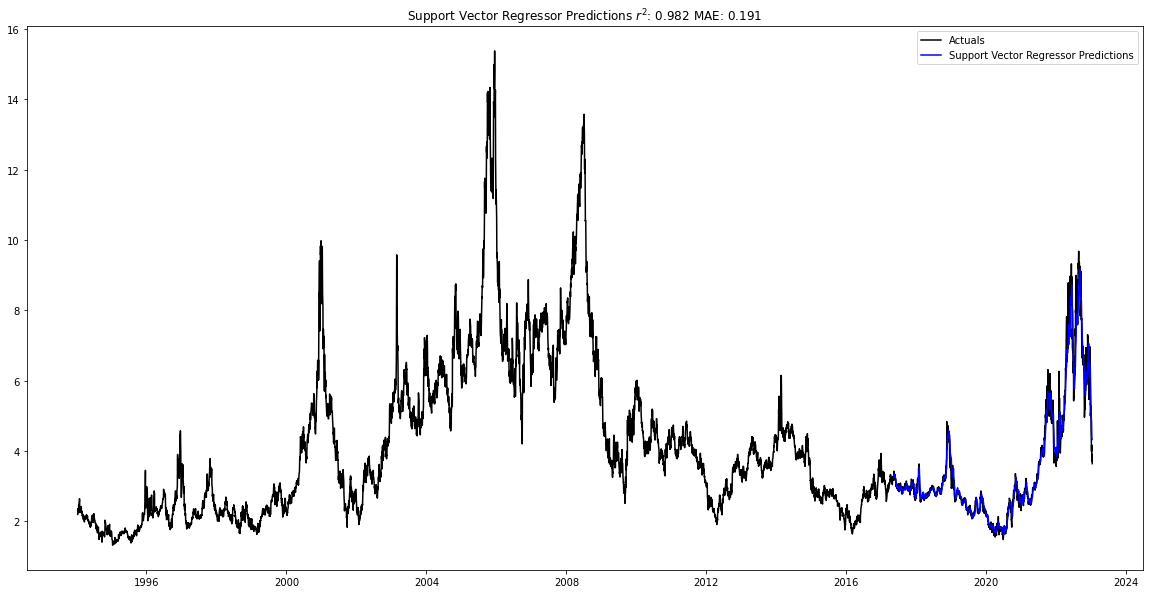

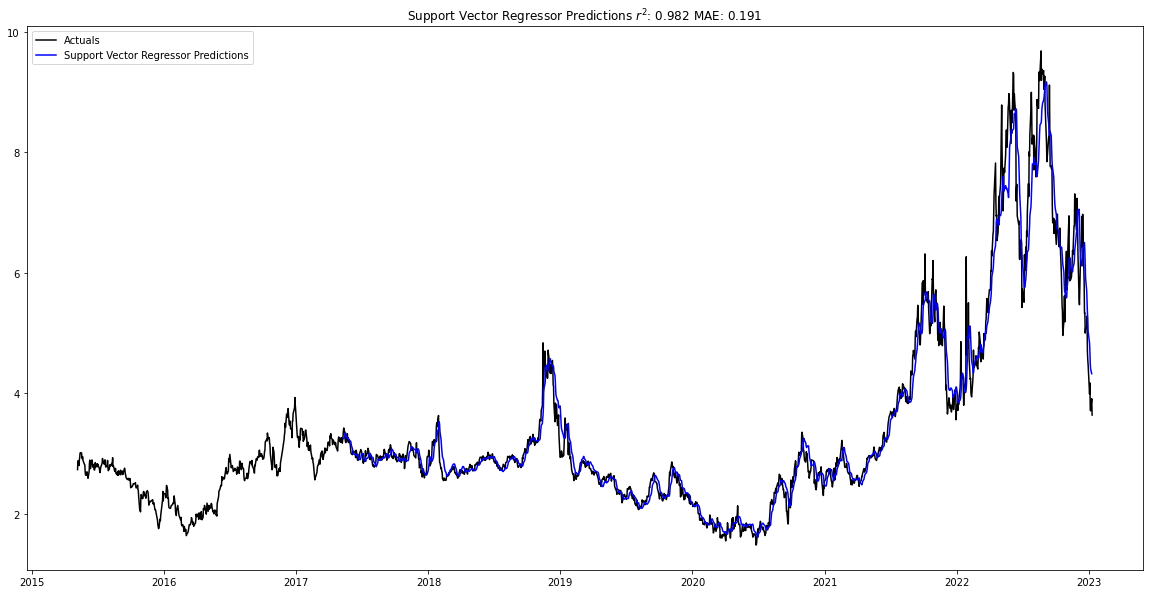

In [85]:
natural_gas_forecast.plot_best_model()

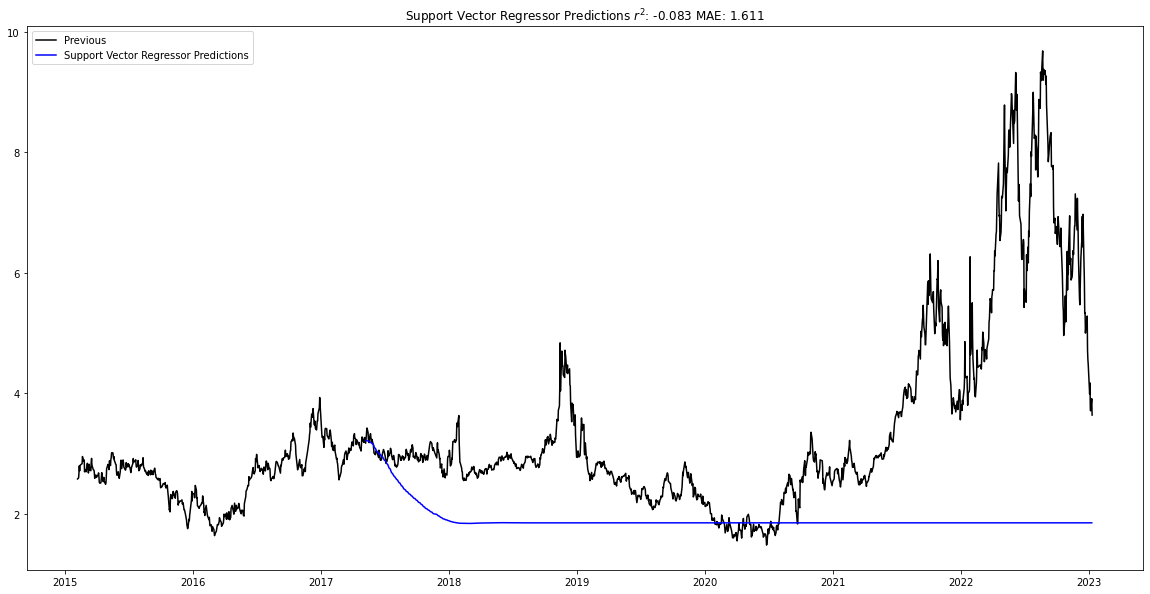

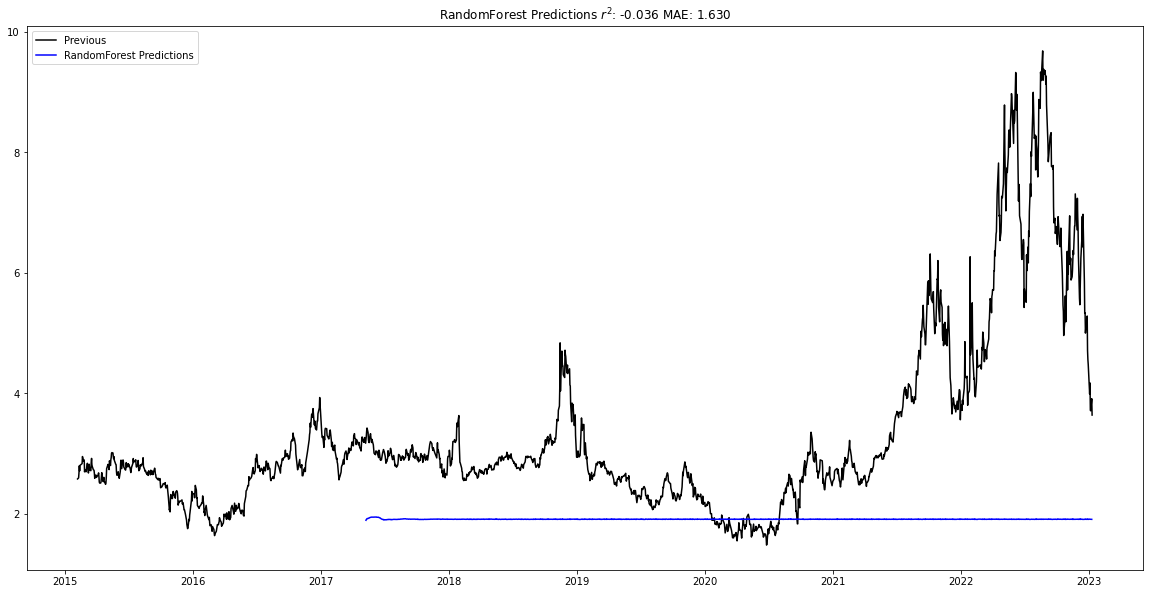

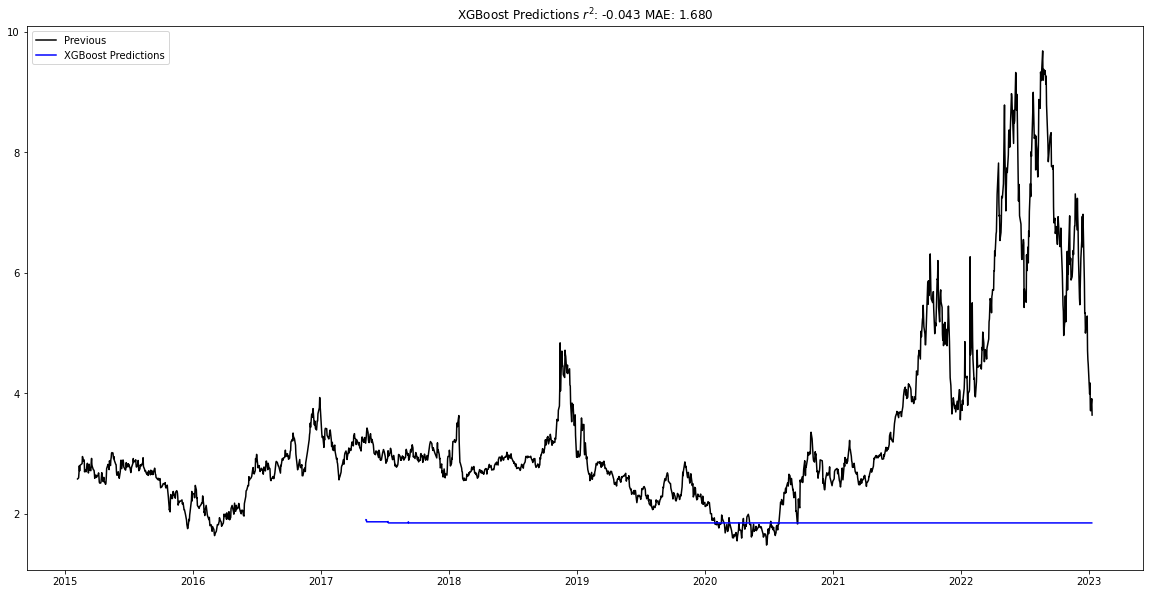

In [15]:
natural_gas_forecast.plot_data()

## Forecasting Petroleum Futures
I'll now run through the same process by forecasting New York Harbor No. 2 Heating Oil Future Contract 1.

In [11]:
petroleum_forecast = LoadQuery()
petroleum_forecast.run_all()

Choose your id
id:  coal  Name:  Coal 
id:  crude-oil-imports  Name:  Crude Oil Imports 
id:  electricity  Name:  Electricity 
id:  international  Name:  International 
id:  natural-gas  Name:  Natural Gas 
id:  nuclear-outages  Name:  Nuclear Outages 
id:  petroleum  Name:  Petroleum 
id:  seds  Name:  State Energy Data System (SEDS) 
id:  steo  Name:  Short Term Energy Outlook 
id:  densified-biomass  Name:  Densified Biomass 
id:  total-energy  Name:  Total Energy 
id:  aeo  Name:  Annual Energy Outlook 
id:  ieo  Name:  International Energy Outlook 
id:  co2-emissions  Name:  State CO2 Emissions 
petroleum
Choose your id
id:  sum  Name:  Summary 
id:  pri  Name:  Prices 
id:  crd  Name:  Crude Reserves and Production 
id:  pnp  Name:  Refining and Processing 
id:  move  Name:  Imports/Exports and Movements 
id:  stoc  Name:  Stocks 
id:  cons  Name:  Consumption/Sales 
pri
Choose your id
id:  gnd  Name:  Weekly Retail Gasoline and Diesel Prices 
id:  spt  Name:  Spot Prices 
id:  f

In [89]:
petroleum_forecast.df.head().to_markdown()

'| time_idx            | period              | duoarea   | area-name     | product   | product-name                | process   | process-name      | series                  | series-description                                                       |   value | units   |\n|:--------------------|:--------------------|:----------|:--------------|:----------|:----------------------------|:----------|:------------------|:------------------------|:-------------------------------------------------------------------------|--------:|:--------|\n| 1980-01-02 00:00:00 | 1980-01-02 00:00:00 | Y35NY     | NEW YORK CITY | EPD2F     | No 2 Fuel Oil / Heating Oil | PE1       | Future Contract 1 | EER_EPD2F_PE1_Y35NY_DPG | New York Harbor No. 2 Heating Oil Future Contract 1 (Dollars per Gallon) |   0.821 | $/GAL   |\n| 1980-01-02 00:00:00 | 1980-01-02 00:00:00 | Y35NY     | NEW YORK CITY | EPD2F     | No 2 Fuel Oil / Heating Oil | PE3       | Future Contract 3 | EER_EPD2F_PE3_Y35NY_DPG | New York Harbor

In [90]:
petroleum_forecast.df['series-description'].unique()

array(['New York Harbor No. 2 Heating Oil Future Contract 1 (Dollars per Gallon)',
       'New York Harbor No. 2 Heating Oil Future Contract 3 (Dollars per Gallon)',
       'Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)',
       'Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)',
       'New York Harbor Regular Gasoline Future Contract 3 (Dollars per Gallon)',
       'Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)',
       'New York Harbor Regular Gasoline Future Contract 1 (Dollars per Gallon)',
       'Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)',
       'Mont Belvieu, Tx Propane Future Contract 1 (Dollars per Gallon)',
       'Mont Belvieu, Tx Propane Future Contract 4 (Dollars per Gallon)',
       'New York Harbor No. 2 Heating Oil Future Contract 4 (Dollars per Gallon)',
       'New York Harbor Regular Gasoline Future Contract 2 (Dollars per Gallon)',
       'New York Harbor Regular Gasoline Future Contract 4 (Dollars per G

In [93]:
petroleum_forecast_data = petroleum_forecast.df[petroleum_forecast.df['series-description'] == 'New York Harbor No. 2 Heating Oil Future Contract 1 (Dollars per Gallon)']
petroleum_forecast_data = petroleum_forecast_data.dropna()

After training the different models, this time the XGBoost regressor had the smallest MAE at 0.080 and the largest $r^2$ at 0.985 for the testing data.

Training Support Vector Regressor
Support Vector Regressor trained
Training RandomForest
RandomForest trained
Training XGBoost
XGBoost trained


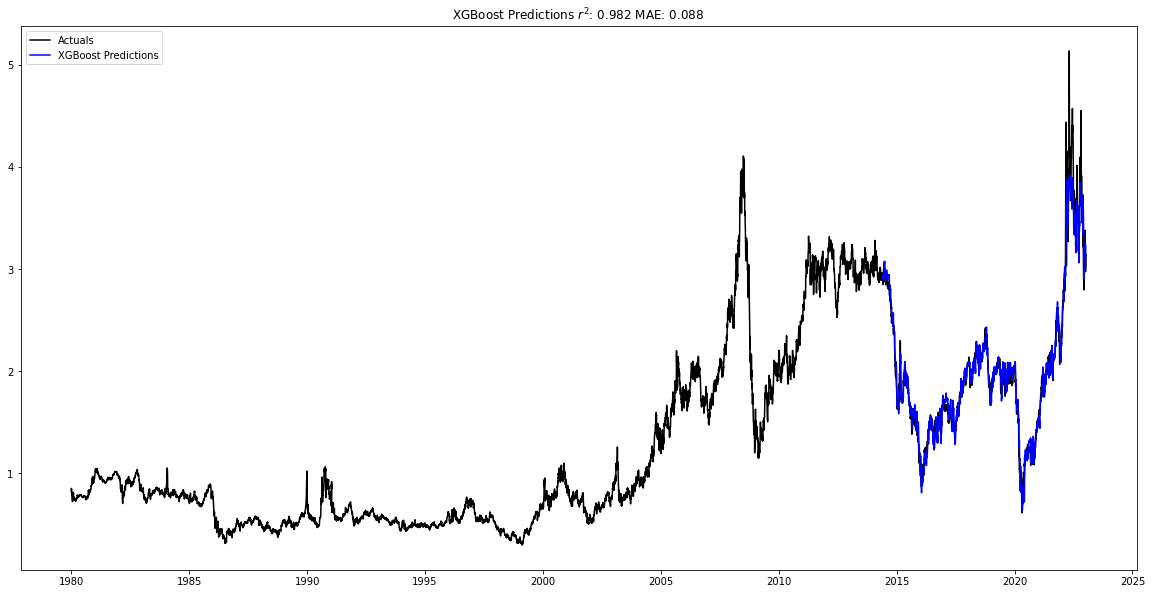

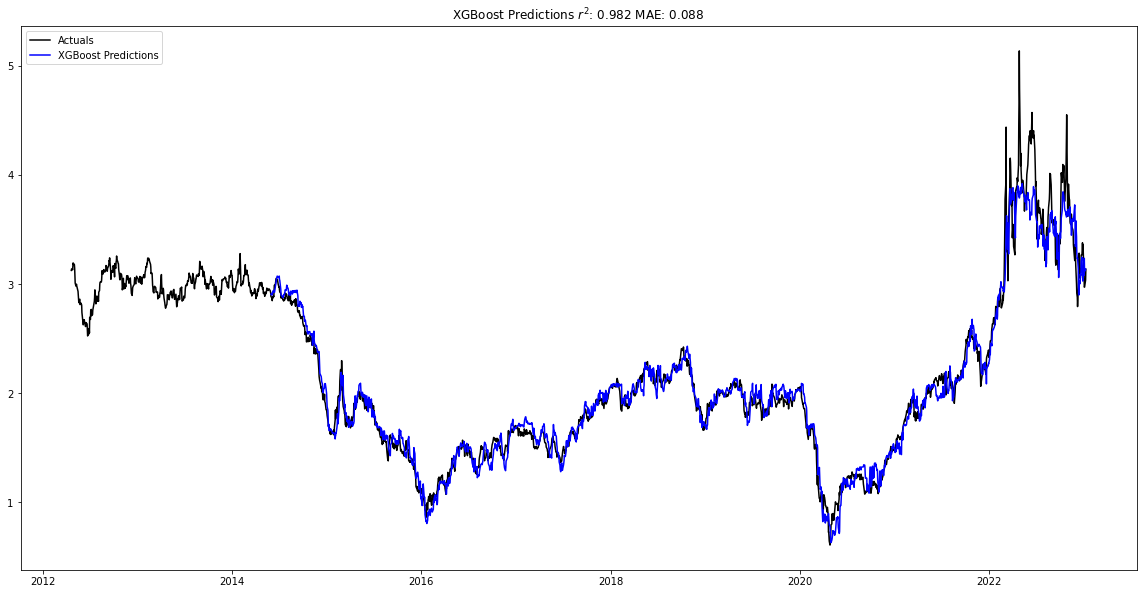

In [95]:
petroleum_forecast_model = ForecastModel(df = petroleum_forecast_data, num_shifts = 50, num_predict = 150, col = 'value')
petroleum_forecast_model.find_best_model()

Looking at the rest of the models, we see that the Support Vector regressor also predicted the data very well, while the RandomForest regressor was unable to capture the trend.

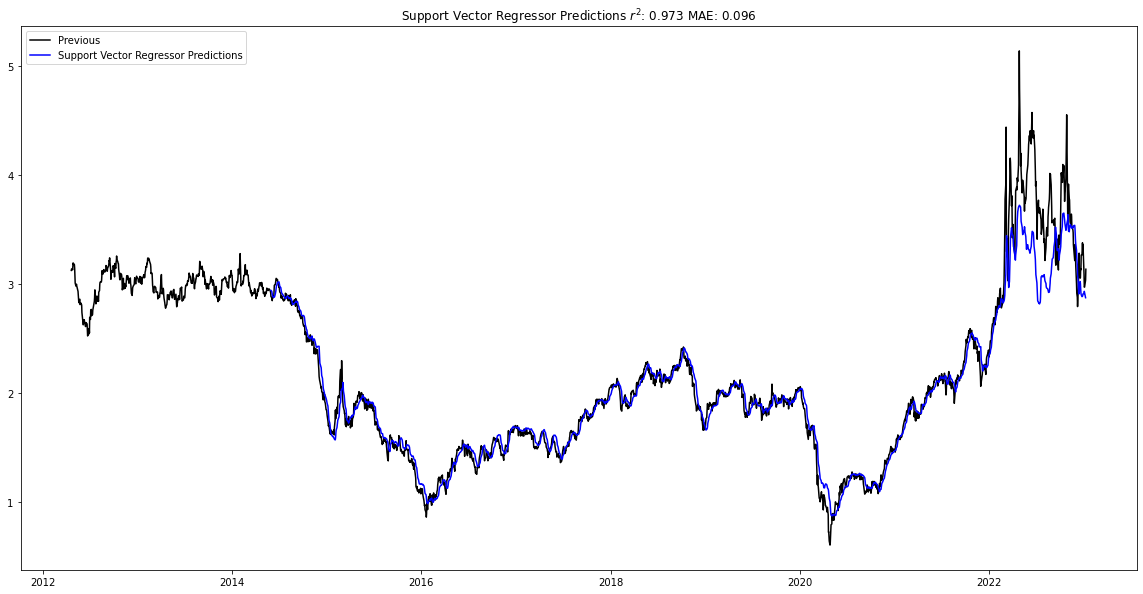

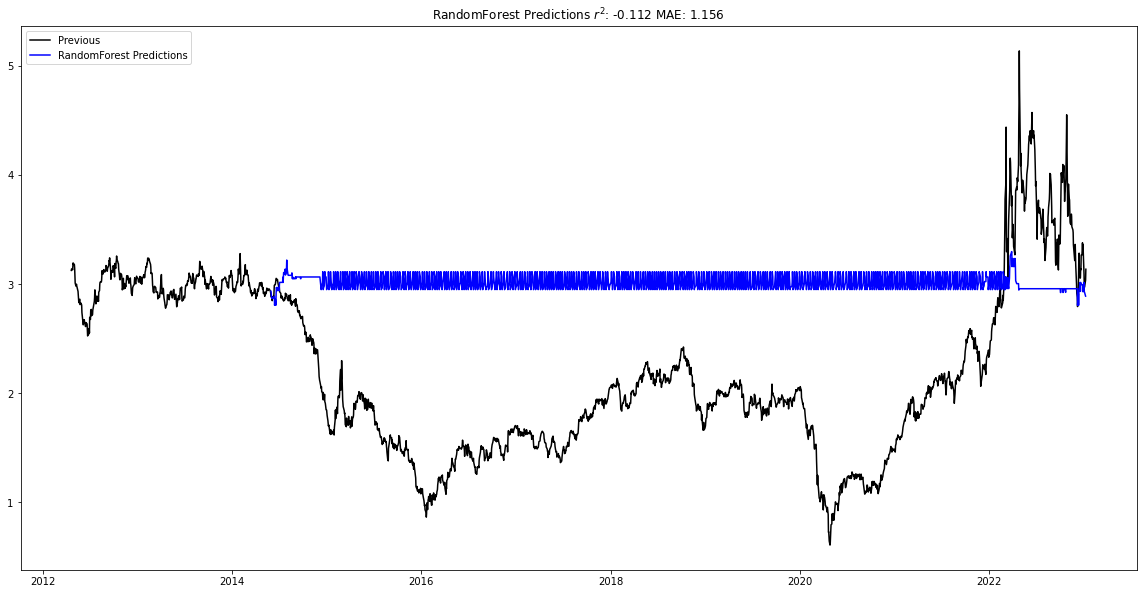

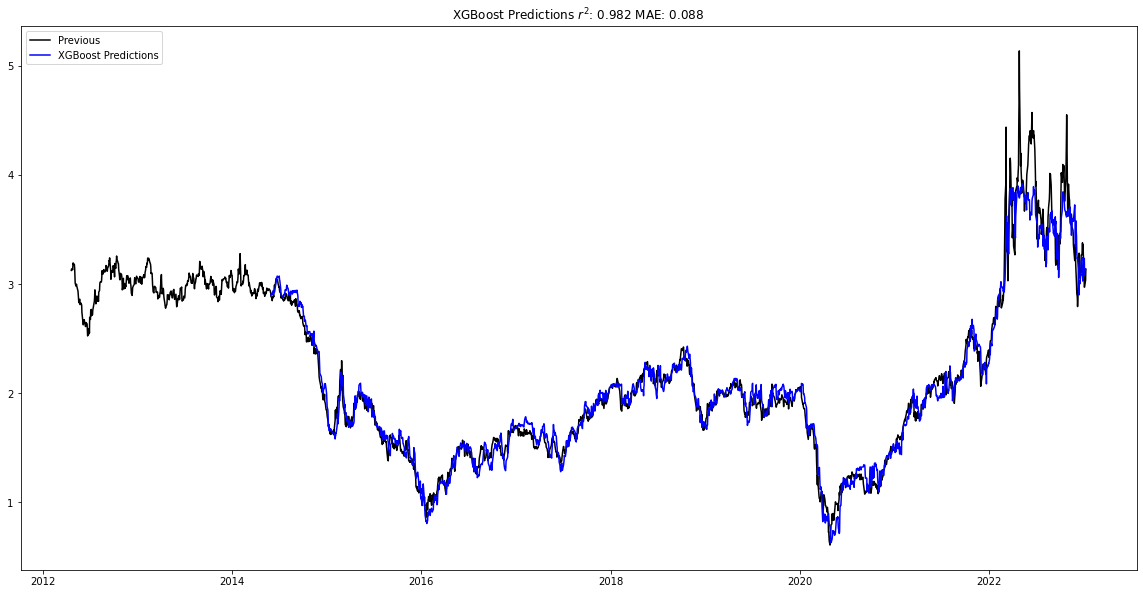

In [96]:
petroleum_forecast_model.plot_data()

## Conclusions and Next Steps

Taking a look at the natural gas and petroleum futures predictions, we are able to see that the models captured the volatility due to the Covid-19 pandemic and the invasion of Ukraine in their forecasting. As a result, it seems that univariate time-series models can be useful and cost-effective in forecasting markets.

I believe that there are several ways to improve this project. First, when testing the models across other datasets, the models were occassionally unable to capature seasonality in the data. As a result, when data appears more seasonal, performing a seasonality decomposition could increase model performance. Secondly, there were some datasets where models had more difficulty making predictions. Creating a multivariate model that incorporates features such as GDP, local and international conflicts, different weather events, and location could improve model performance as well.